In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import scipy.stats

In [34]:
parameters = {
    'A': {
        'incidence': 0.2,
        'beta_counts': 10,
        'color': 'b'
    },
    'B': {
        'incidence': 0.2,
        'beta_counts': 20,
        'color': 'g'
    }
}

In [89]:
# Compute beta parameters
for key, value in parameters.items():
    parameters[key]['alpha'] = value['incidence'] * value['beta_counts']
    parameters[key]['beta'] = (1-value['incidence']) * value['beta_counts']
    
    # Compute the unconditional distribution
    parameters[key]['x'] = np.linspace(
        scipy.stats.beta.ppf(0.00, parameters[key]['alpha'], parameters[key]['beta']),
        scipy.stats.beta.ppf(0.999, parameters[key]['alpha'], parameters[key]['beta']), 
        100
    )
    parameters[key]['x'] = np.linspace(
        0.001,
        0.999,
        1000
    )
    parameters[key]['pdf'] = scipy.stats.beta.pdf(parameters[key]['x'], parameters[key]['alpha'], parameters[key]['beta'])
    
    # Compute the conditional distributions
    parameters[key]['pdf_1'] = parameters[key]['x']*parameters[key]['pdf'] / parameters[key]['incidence']
    parameters[key]['pdf_0'] = (1-parameters[key]['x'])*parameters[key]['pdf'] / (1-parameters[key]['incidence'])
    parameters[key]['calibration_curve'] = (parameters[key]['pdf_1']*parameters[key]['incidence']) / parameters[key]['pdf']

In [132]:
def plot_distributions(
    plot_x='x', 
    plot_y='pdf', 
    ax=plt.gca(), 
    groups = None, 
    title='', 
    legend=False, 
    apply_fill=True,
    fill_min=None, 
    fill_max=None,
    threshold = None,
    calibration_curve=False
):
    
    if groups is None:
        groups = parameters.keys()
        
    for key in groups:
        
        ax.plot(parameters[key][plot_x], parameters[key][plot_y], color=parameters[key]['color'])
        
        if apply_fill:
            if fill_min is None:
                fill_min = parameters[key][plot_x].min()
            if fill_max is None:
                fill_max = parameters[key][plot_x].max()

            fill_mask = (parameters[key][plot_x] >= fill_min) & (parameters[key][plot_x] <= fill_max)
            ax.fill_between(
                parameters[key][plot_x][fill_mask], 0, parameters[key][plot_y][fill_mask], color=parameters[key]['color'], alpha=0.5, label=f'Group {key}'
            )
        if threshold is not None:
            ax.axvline(threshold, color=parameters[key]['color'], linestyle='--')
            
        if calibration_curve:
            # Plot a dashed x=y for comparison with perfect calibration
            ax.plot(parameters[key][plot_x], parameters[key][plot_x], linestyle='--')
#             ax.set_ylim([0, 1])

    ax.set_xlim([0, 1])
    ax.set_title(title)
#     ax.set_aspect(0.25)

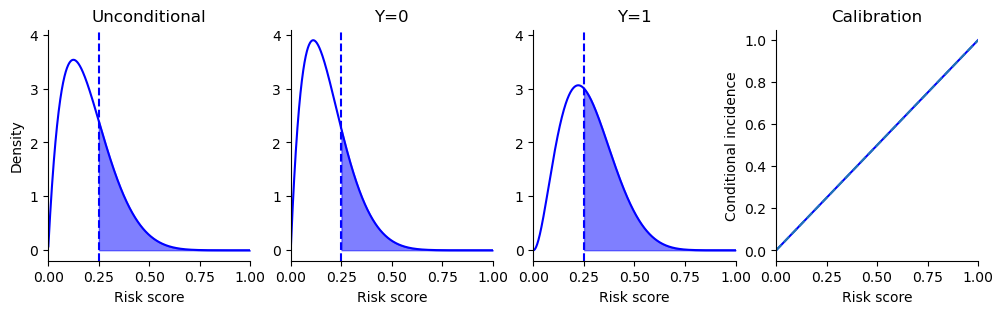

In [177]:
# Plot for group A

plt.close()
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(12,3), sharey=False, sharex=True)
axes = [ax1, ax2, ax3, ax4]

threshold = 0.25
    
plot_distributions(plot_y='pdf', ax=ax1, title='Unconditional', groups='A', fill_min=threshold, threshold=threshold)
plot_distributions(plot_y='pdf_0', ax=ax2, title='Y=0', groups='A', fill_min=threshold, threshold=threshold)
plot_distributions(plot_y='pdf_1', ax=ax3, title='Y=1', groups='A', fill_min=threshold, threshold=threshold)

plot_distributions(plot_y='calibration_curve', ax=ax4, title='Calibration', groups='A', apply_fill=False, 
                   calibration_curve=True)

fig.subplots_adjust(hspace=.5)
ax1.set_ylabel('Density')
ax4.set_ylabel('Conditional incidence')
for ax in axes:
    ax.set_xlabel('Risk score')

ax1.sharey(ax2)
ax3.sharey(ax2)

sns.despine()
plt.show()

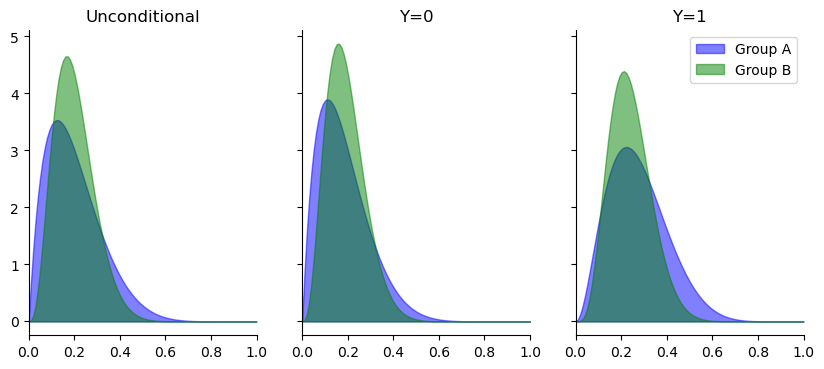

In [48]:
# Plot by group
plt.close()
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(10,5))
    
plot_distributions(plot_y='pdf', ax=ax1, title='Unconditional')
plot_distributions(plot_y='pdf_0', ax=ax2, title='Y=0')
plot_distributions(plot_y='pdf_1', ax=ax3, title='Y=1')

fig.subplots_adjust(hspace=.5)
ax3.legend()
sns.despine()
plt.show()